c:\Users\rosem\Documents\AJ\Thesis-Implementation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully
SHAP version: 0.49.1
Data Loaded:
   Training samples: 436
   Test samples: 110
   Features: 13
   Feature names: 13
Loaded: KNN
Loaded: DECISION_TREE
Loaded: RANDOM_FOREST
Loaded: SVR
Loaded: RIDGE

SHAP (SHAPLEY VALUES) FEATURE IMPORTANCE ANALYSIS - BASE MODELS

Calculating SHAP values for all base models...
This may take several minutes...

[KNN] Computing SHAP values...


100%|██████████| 100/100 [05:34<00:00,  3.34s/it]


   SHAP computation complete for KNN

[DECISION_TREE] Computing SHAP values...
   SHAP computation complete for DECISION_TREE

[RANDOM_FOREST] Computing SHAP values...
   SHAP computation complete for RANDOM_FOREST

[SVR] Computing SHAP values...


100%|██████████| 100/100 [28:21<00:00, 17.02s/it]


   SHAP computation complete for SVR

[RIDGE] Computing SHAP values...


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


   SHAP computation complete for RIDGE

SHAP FEATURE IMPORTANCE RANKINGS

KNN - Top 10 Features by SHAP:
Rank  Feature                  SHAP Importance     
---------------------------------------------------
1     Scholarship              1.396214            
2     ReviewCenter             1.069332            
3     Gender                   1.017908            
4     StudyHours               0.947119            
5     EmploymentStatus         0.933342            
6     GPA                      0.865096            
7     InternshipGrade          0.668177            
8     MockExamScore            0.590445            
9     TestAnxiety              0.568446            
10    IncomeLevel              0.568298            

DECISION_TREE - Top 10 Features by SHAP:
Rank  Feature                  SHAP Importance     
---------------------------------------------------
1     StudyHours               3.144393            
2     MockExamScore            1.219092            
3     Scholarship    

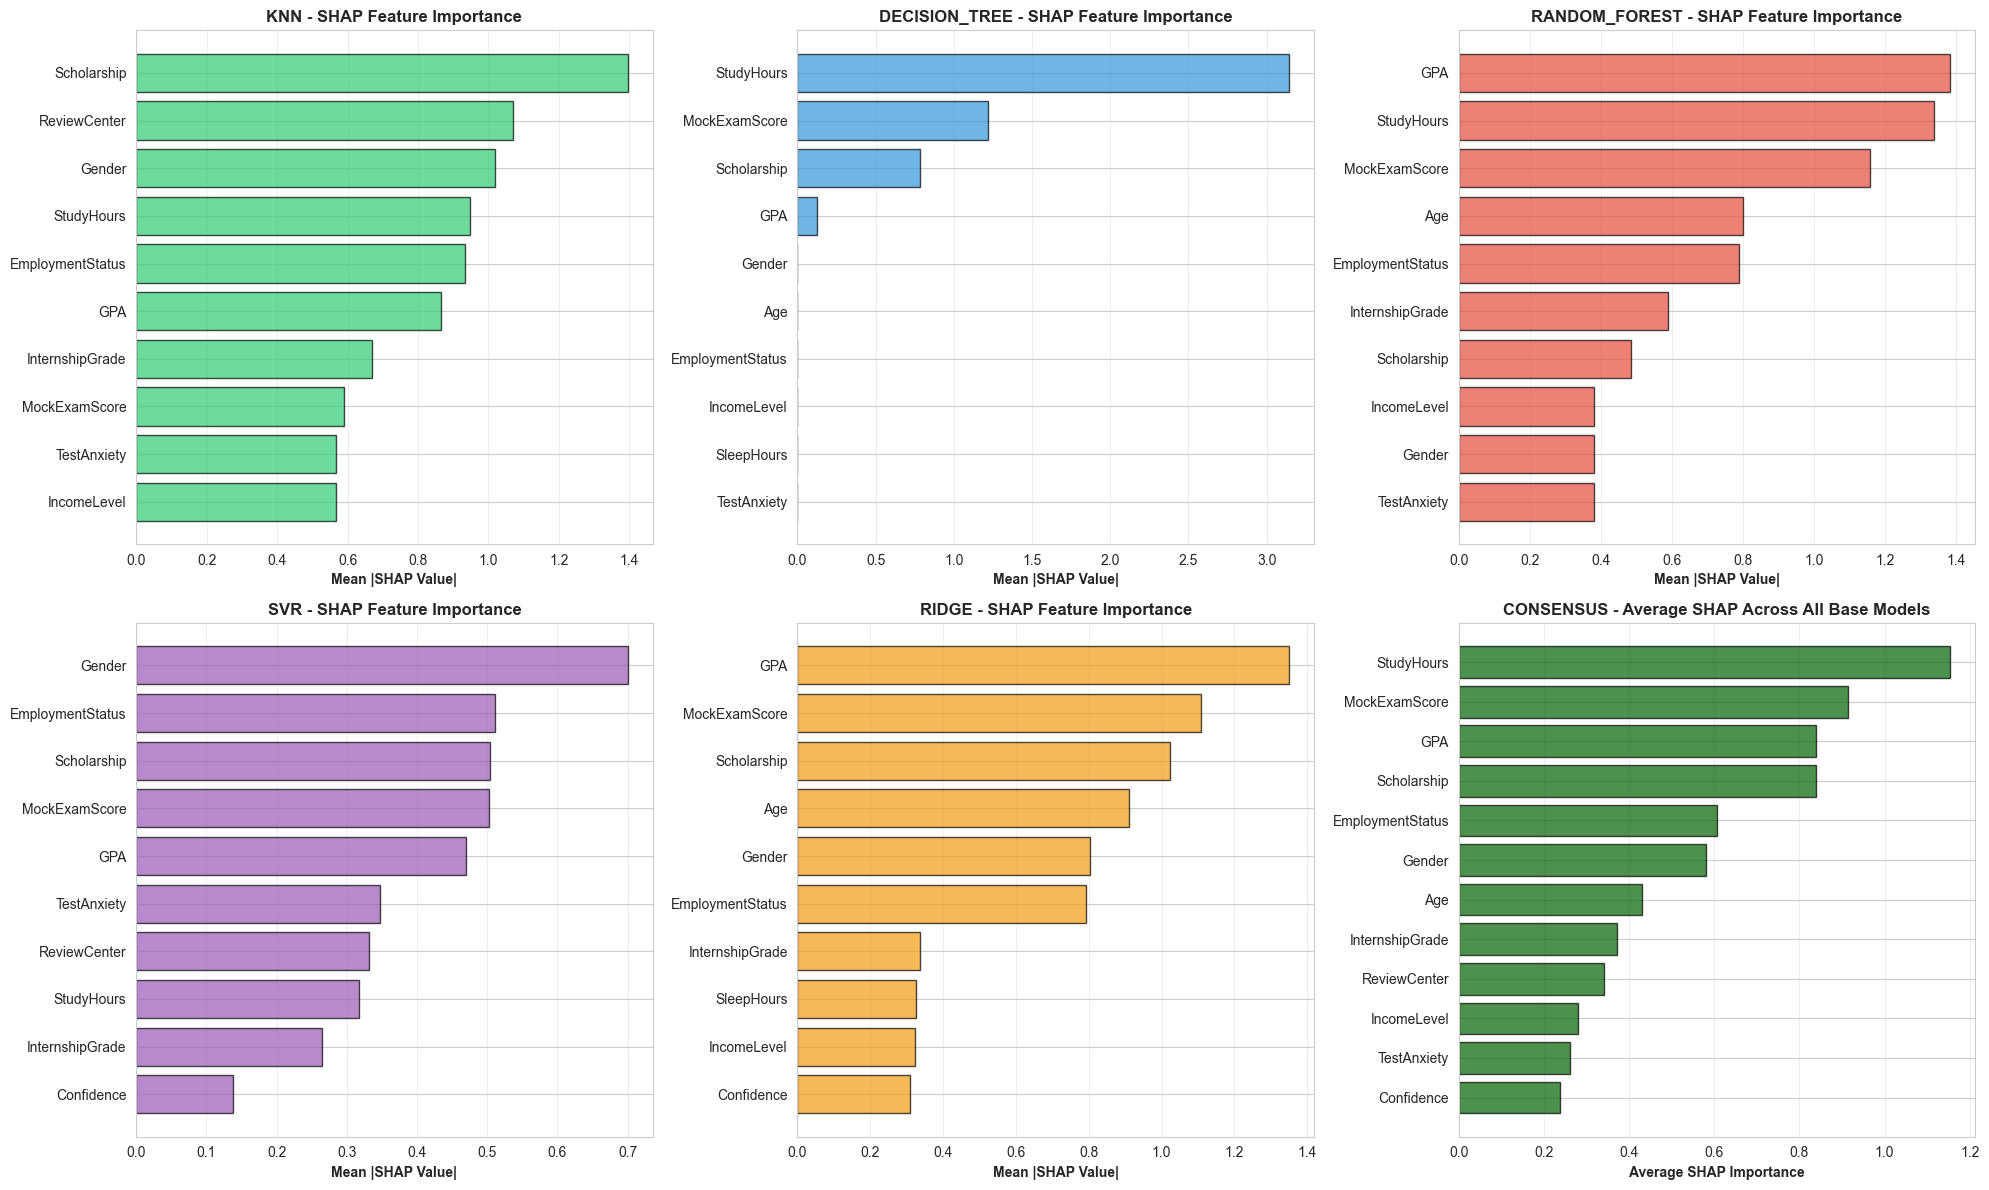


DETAILED SHAP PLOTS FOR RANDOM FOREST (BEST TREE-BASED MODEL)

1. SHAP Summary Plot (Feature Impact Distribution)
Saved: ../saved_base_models/shap_analysis/random_forest_summary_plot.png


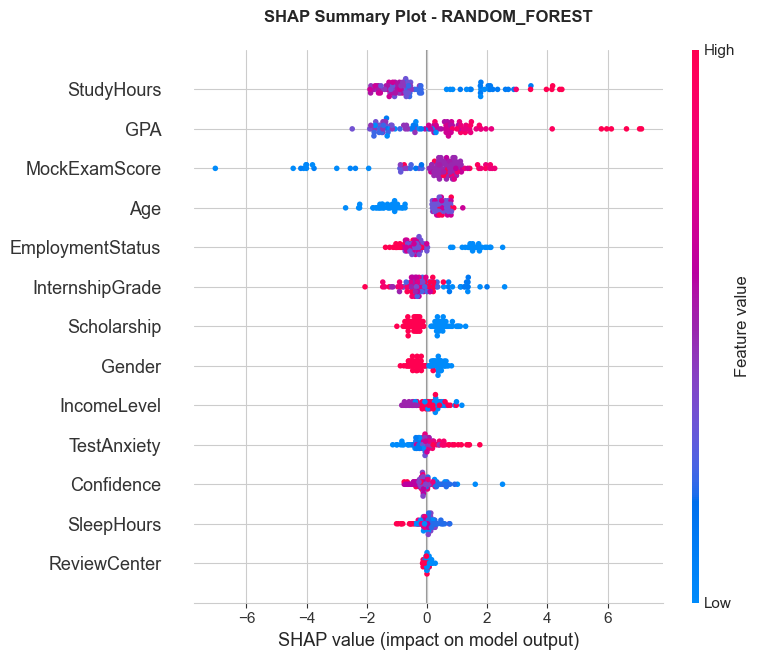


2. SHAP Summary Plot (Bar)
Saved: ../saved_base_models/shap_analysis/random_forest_bar_plot.png


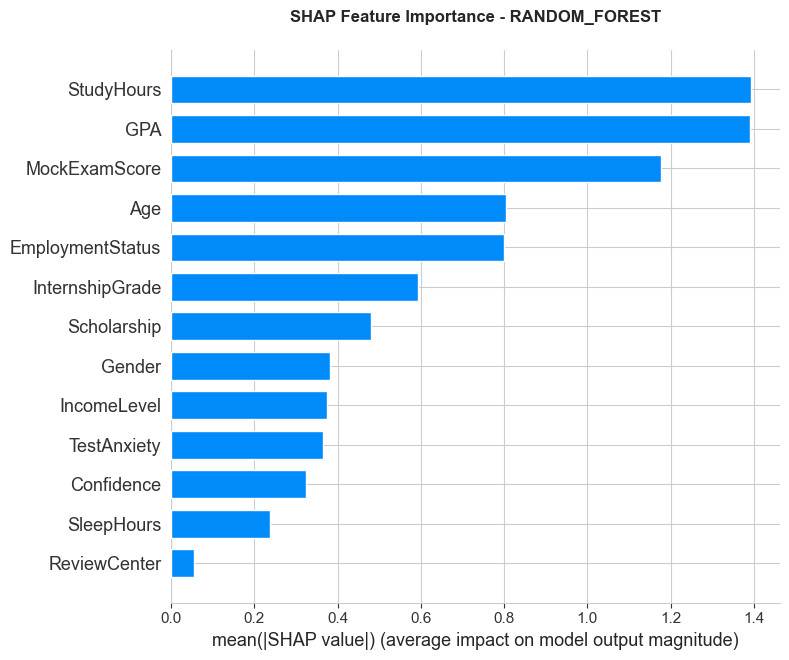


3. SHAP Waterfall Plot (First Prediction)
Saved: ../saved_base_models/shap_analysis/random_forest_waterfall_plot.png


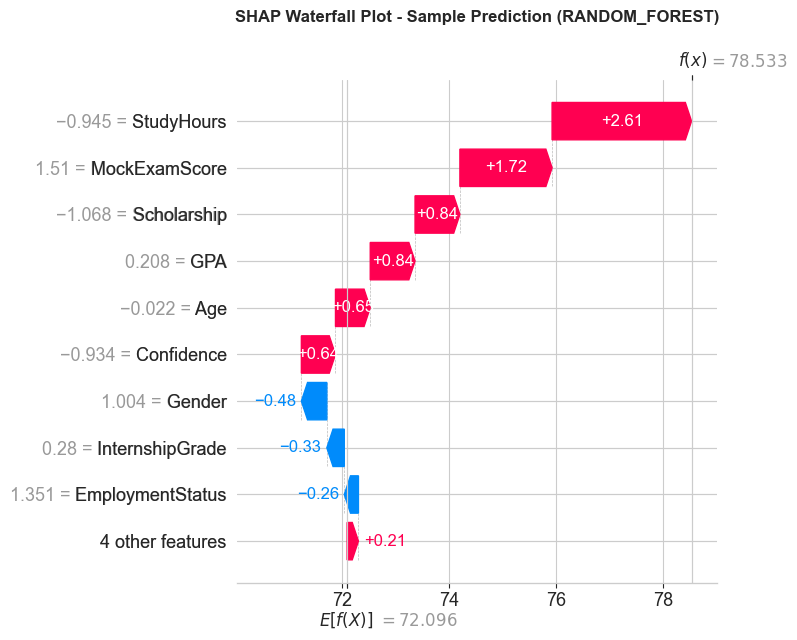


4. SHAP Dependence Plots (Top 3 Features)
Saved: ../saved_base_models/shap_analysis/random_forest_dependence_plots.png


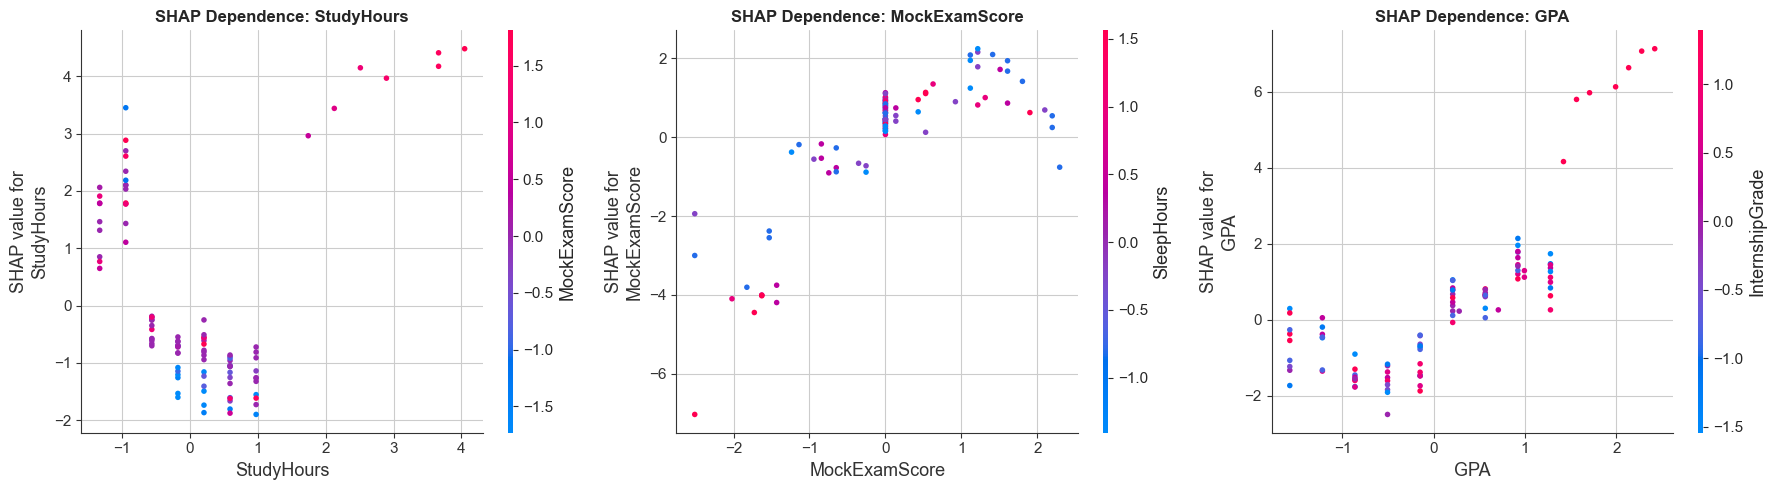


SHAP FORCE PLOTS FOR INDIVIDUAL PREDICTIONS

Force plot for sample 0
Saved: ../saved_base_models/shap_analysis/force_plot_sample_0.png


<Figure size 2000x300 with 0 Axes>

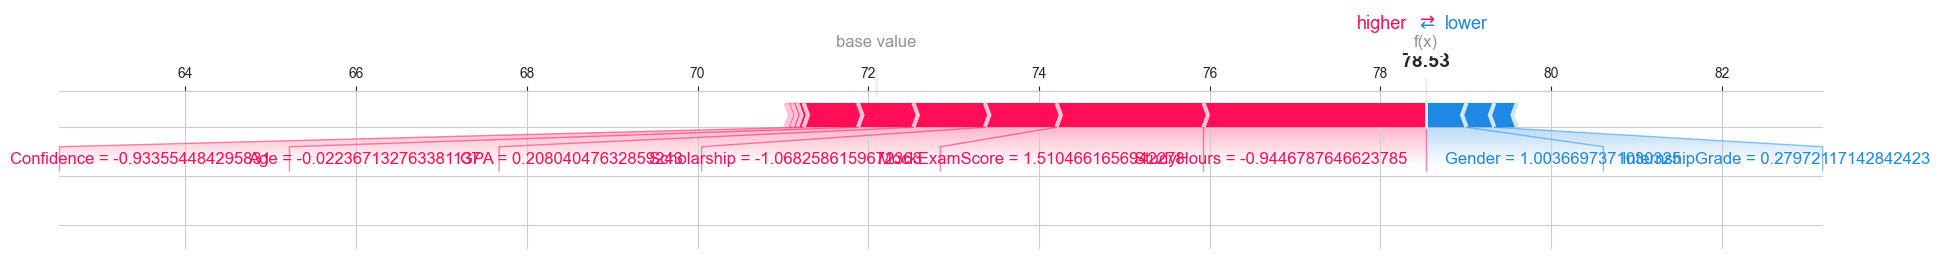


Force plot for sample 1
Saved: ../saved_base_models/shap_analysis/force_plot_sample_1.png


<Figure size 2000x300 with 0 Axes>

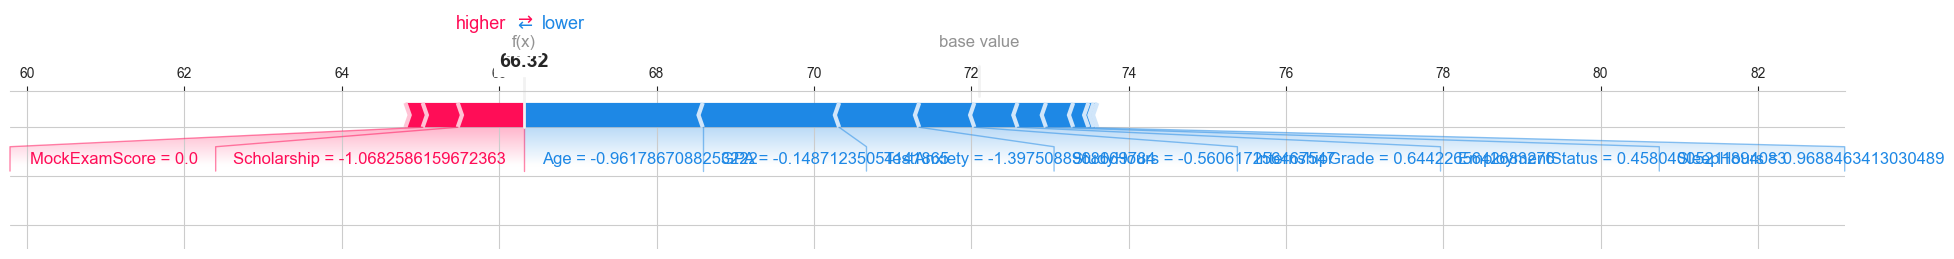


Force plot for sample 2
Saved: ../saved_base_models/shap_analysis/force_plot_sample_2.png


<Figure size 2000x300 with 0 Axes>

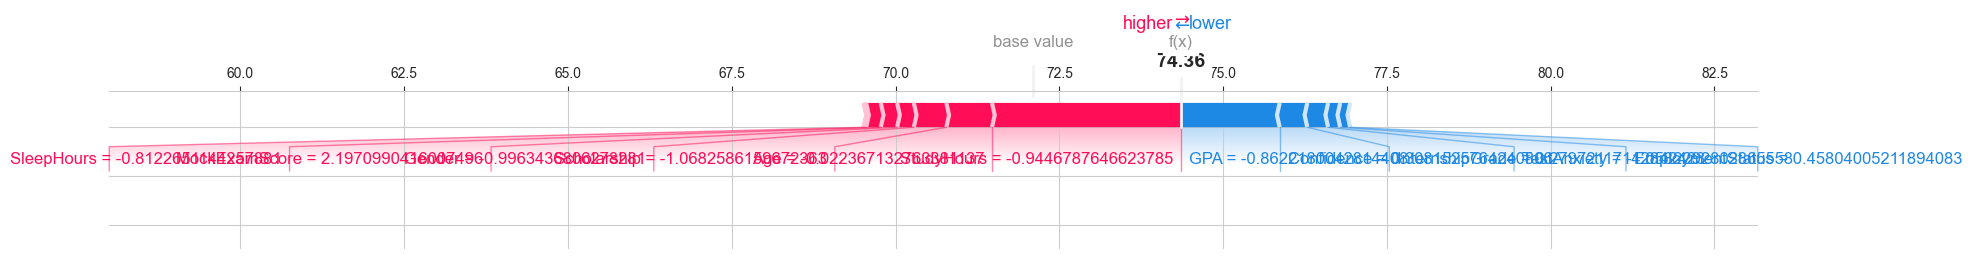


SHAP ANALYSIS COMPLETE

SHAP importance data saved to: ../saved_base_models/shap_analysis/
Files created:
   knn_shap_importance.csv
   decision_tree_shap_importance.csv
   random_forest_shap_importance.csv
   svr_shap_importance.csv
   ridge_shap_importance.csv
   combined_shap_importance.csv
   base_models_shap_comparison.png
   random_forest_summary_plot.png
   random_forest_bar_plot.png
   random_forest_waterfall_plot.png
   random_forest_dependence_plots.png
   force_plot_sample_0.png, force_plot_sample_1.png, force_plot_sample_2.png


In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import shap
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")
print("SHAP version:", shap.__version__)

X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')
feature_names = json.load(open('../regression_processed_data/feature_names.json'))
print(f"Data Loaded:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Feature names: {len(feature_names)}")

models = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge']:
    model_path = f'../saved_base_models/{model_name}_model.pkl'
    models[model_name] = joblib.load(model_path)
    print(f"Loaded: {model_name.upper()}")

print("\n" + "=" * 70)
print("SHAP (SHAPLEY VALUES) FEATURE IMPORTANCE ANALYSIS - BASE MODELS")
print("=" * 70)

shap_results = {}

print("\nCalculating SHAP values for all base models...")
print("This may take several minutes...")

for name, model in models.items():
    print(f"\n[{name.upper()}] Computing SHAP values...")
    
    if name in ['random_forest', 'decision_tree']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    
    elif name in ['knn', 'svr', 'ridge']:
        background = shap.sample(X_train, 100)
        explainer = shap.KernelExplainer(model.predict, background)
        shap_values = explainer.shap_values(X_test[:100])
    
    shap_results[name] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'feature_importance': np.abs(shap_values).mean(axis=0)
    }
    
    print(f"   SHAP computation complete for {name.upper()}")

print("\n" + "=" * 70)
print("SHAP FEATURE IMPORTANCE RANKINGS")
print("=" * 70)

shap_importance_df_list = []

for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False)
    
    shap_importance_df_list.append(importance_df)
    
    print(f"\n{name.upper()} - Top 10 Features by SHAP:")
    print(f"{'Rank':<6}{'Feature':<25}{'SHAP Importance':<20}")
    print("-" * 51)
    
    for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"{i:<6}{row['Feature']:<25}{row['SHAP_Importance']:<20.6f}")

combined_shap = pd.DataFrame({
    'Feature': feature_names
})

for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        f'{name}_shap': shap_data['feature_importance']
    })
    combined_shap = combined_shap.merge(importance_df, on='Feature')

shap_cols = [col for col in combined_shap.columns if col.endswith('_shap')]
combined_shap['avg_shap'] = combined_shap[shap_cols].mean(axis=1)
combined_shap = combined_shap.sort_values('avg_shap', ascending=False)

print("\n" + "=" * 70)
print("CONSENSUS SHAP FEATURE IMPORTANCE (Averaged Across All Base Models)")
print("=" * 70)

print(f"\n{'Rank':<6}{'Feature':<25}{'Average SHAP':<20}")
print("-" * 51)

for i, (idx, row) in enumerate(combined_shap.head(12).iterrows(), 1):
    print(f"{i:<6}{row['Feature']:<25}{row['avg_shap']:<20.6f}")

print("\n" + "=" * 70)
print("SHAP VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for idx, (name, shap_data) in enumerate(shap_results.items()):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False).head(10)
    
    axes[idx].barh(importance_df['Feature'], importance_df['SHAP_Importance'],
                   color=colors[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Mean |SHAP Value|', fontweight='bold')
    axes[idx].set_title(f'{name.upper()} - SHAP Feature Importance', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

axes[5].barh(combined_shap.head(12)['Feature'], combined_shap.head(12)['avg_shap'],
             color='darkgreen', edgecolor='black', alpha=0.7)
axes[5].set_xlabel('Average SHAP Importance', fontweight='bold')
axes[5].set_title('CONSENSUS - Average SHAP Across All Base Models', fontweight='bold')
axes[5].invert_yaxis()
axes[5].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../saved_base_models/shap_analysis/base_models_shap_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: ../saved_base_models/shap_analysis/base_models_shap_comparison.png")
plt.show()

print("\n" + "=" * 70)
print("DETAILED SHAP PLOTS FOR RANDOM FOREST (BEST TREE-BASED MODEL)")
print("=" * 70)

best_model_name = 'random_forest'
best_shap_values = shap_results[best_model_name]['shap_values']
best_explainer = shap_results[best_model_name]['explainer']

sample_size = min(100, X_test.shape[0])

print(f"\n1. SHAP Summary Plot (Feature Impact Distribution)")
plt.figure(figsize=(12, 8))
shap.summary_plot(best_shap_values[:sample_size], 
                 X_test[:sample_size], 
                 feature_names=feature_names,
                 show=False)
plt.title(f'SHAP Summary Plot - {best_model_name.upper()}', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../saved_base_models/shap_analysis/random_forest_summary_plot.png', dpi=300, bbox_inches='tight')
print("Saved: ../saved_base_models/shap_analysis/random_forest_summary_plot.png")
plt.show()

print(f"\n2. SHAP Summary Plot (Bar)")
plt.figure(figsize=(12, 8))
shap.summary_plot(best_shap_values[:sample_size], 
                 X_test[:sample_size], 
                 feature_names=feature_names,
                 plot_type="bar",
                 show=False)
plt.title(f'SHAP Feature Importance - {best_model_name.upper()}', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../saved_base_models/shap_analysis/random_forest_bar_plot.png', dpi=300, bbox_inches='tight')
print("Saved: ../saved_base_models/shap_analysis/random_forest_bar_plot.png")
plt.show()

print(f"\n3. SHAP Waterfall Plot (First Prediction)")
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(values=best_shap_values[0],
                    base_values=best_explainer.expected_value,
                    data=X_test[0],
                    feature_names=feature_names),
    show=False
)
plt.title(f'SHAP Waterfall Plot - Sample Prediction ({best_model_name.upper()})', 
         fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../saved_base_models/shap_analysis/random_forest_waterfall_plot.png', dpi=300, bbox_inches='tight')
print("Saved: ../saved_base_models/shap_analysis/random_forest_waterfall_plot.png")
plt.show()

top_features = combined_shap.head(3)['Feature'].tolist()

print(f"\n4. SHAP Dependence Plots (Top 3 Features)")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_features):
    feature_idx = feature_names.index(feature)
    
    shap.dependence_plot(
        feature_idx,
        best_shap_values[:sample_size],
        X_test[:sample_size],
        feature_names=feature_names,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold')

plt.tight_layout()
plt.savefig('../saved_base_models/shap_analysis/random_forest_dependence_plots.png', dpi=300, bbox_inches='tight')
print("Saved: ../saved_base_models/shap_analysis/random_forest_dependence_plots.png")
plt.show()

print("\n" + "=" * 70)
print("SHAP FORCE PLOTS FOR INDIVIDUAL PREDICTIONS")
print("=" * 70)

sample_indices = [0, 1, 2]

for sample_idx in sample_indices:
    print(f"\nForce plot for sample {sample_idx}")
    plt.figure(figsize=(20, 3))
    
    shap.force_plot(
        best_explainer.expected_value,
        best_shap_values[sample_idx],
        X_test[sample_idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    
    plt.tight_layout()
    plt.savefig(f'../saved_base_models/shap_analysis/force_plot_sample_{sample_idx}.png', 
                dpi=300, bbox_inches='tight')
    print(f"Saved: ../saved_base_models/shap_analysis/force_plot_sample_{sample_idx}.png")
    plt.show()

os.makedirs('../saved_base_models/shap_analysis', exist_ok=True)

for name, shap_data in shap_results.items():
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_data['feature_importance']
    }).sort_values('SHAP_Importance', ascending=False)
    
    importance_df.to_csv(f'../saved_base_models/shap_analysis/{name}_shap_importance.csv', index=False)

combined_shap.to_csv('../saved_base_models/shap_analysis/combined_shap_importance.csv', index=False)

#save
print("\n" + "=" * 70)
print("SHAP ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nSHAP importance data saved to: ../saved_base_models/shap_analysis/")
print(f"Files created:")
for name in shap_results.keys():
    print(f"   {name}_shap_importance.csv")
print(f"   combined_shap_importance.csv")
print(f"   base_models_shap_comparison.png")
print(f"   random_forest_summary_plot.png")
print(f"   random_forest_bar_plot.png")
print(f"   random_forest_waterfall_plot.png")
print(f"   random_forest_dependence_plots.png")
print(f"   force_plot_sample_0.png, force_plot_sample_1.png, force_plot_sample_2.png")